# Classic methods of text classification

### Yelp Review Rating Classification

A machine learning project for sentiment analysis and rating prediction of Yelp reviews using TF-IDF feature extraction and neural networks.

### Project Overview

This project implements a multi-class classification system to predict Yelp review ratings (1-5 stars) based on review text. The solution combines traditional NLP feature extraction methods with neural network classifiers.

### Dataset

We use the **Yelp Review Full** dataset from Hugging Face:
- **Dataset**: [Yelp/yelp_review_full](https://huggingface.co/datasets/Yelp/yelp_review_full)
- **Features**:
  - `text`: The review text content
  - `label`: Rating label (0-4, corresponding to 1-5 stars respectively)

### Technical Approach

#### Data Preprocessing
- Split the original training data to create a dedicated validation set
- Applied dataset size constraints (training set limited to 100,000 samples)
- Maintained proportional splits for validation and test sets

#### Feature Extraction
- **TF-IDF (Term Frequency-Inverse Document Frequency)** implementation
- **Bag-of-Words** representation using `TfidfVectorizer` from `scikit-learn`
- Text vectorization for neural network compatibility



Import libraries

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.5.1+cu121


In [2]:
import wandb

# Loging to Weights&Biases website to monitor my experiments
wandb.login()

c:\Users\kacpe\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
c:\Users\kacpe\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may

True

# Load dataset

In [3]:
from datasets import load_dataset

ds = load_dataset("Yelp/yelp_review_full")

test_dataset = ds["test"]
splitted_dataset = ds["train"].train_test_split(test_size=0.2)
train_dataset = splitted_dataset["train"]
val_dataset = splitted_dataset["test"]

# Create smaller data subsets
train_dataset = train_dataset.shuffle().select(range(int(len(train_dataset)*0.1)))
val_dataset = val_dataset.shuffle().select(range(int(len(val_dataset)*0.1)))
test_dataset = test_dataset.shuffle().select(range(int(len(test_dataset)*0.4)))

print(f"Test set size: {len(test_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Training set size: {len(train_dataset)}")

sample = train_dataset[123]
print(f"\nExample element from the dataset:")
print(f"{sample['text']=}")
print(f"{sample['label']=}")

c:\Users\kacpe\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Test set size: 20000
Validation set size: 13000
Training set size: 52000

Example element from the dataset:
sample['text']="Monta neighbors Nakamura-Ya, & Raku. With an authentic sushi place to join the strip mall, this is the spot to get some kick-butt Japanese food. Monta is a ramen-specialty restaurant that is not to be skipped!\\n\\nRAMEN: Their menu is small but mighty. What kind of ramen you like? Miso, Shoyu, or Tonkatsu? They come with thin slices of char-siu pork. Ichiza actually has my favorite char-siu.... but Monta's is a solid second. Overall, the ramen here is far superior anyway. There's also a variety of toppings you can add for an additional cost. Generally, I order the same thing every time: Miso Ramen w/ Egg & Nori. YUM! I've sampled every type of soup but Miso is my favorite. The broth is rich & flavorful and I can't find it as good anywhere else.\\n\\nAPPETIZERS: If fish eggs are your thing, Monta has the freshest Mentaiko in Las Vegas. Order a Mini Mentaiko Bowl (

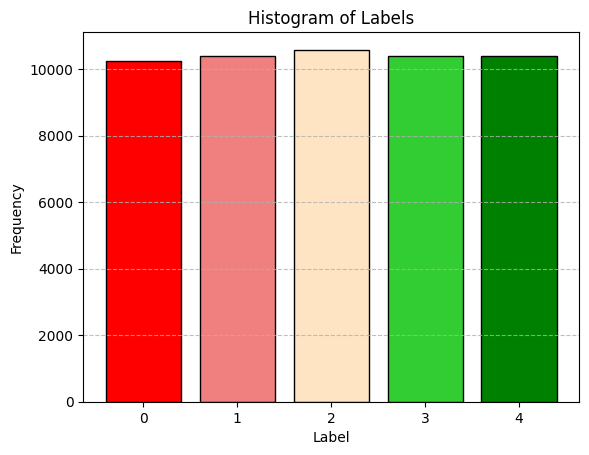

In [4]:
unique_labels, counts = np.unique(train_dataset["label"], return_counts=True)

plt.bar(unique_labels, counts, color=["red", "lightcoral", "bisque", "limegreen", "green"], edgecolor='black')
plt.title('Histogram of Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(unique_labels)
plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.show()

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from tqdm import tqdm

vocab_size = 10000

vectorizer = TfidfVectorizer(
    max_features=vocab_size,
    lowercase=True,
    analyzer='word',
    ngram_range=(1, 1),
    stop_words="english"
)

# Feature extraction
train_tfidf_features = vectorizer.fit_transform(train_dataset["text"])
# On validation and test sets we use transform() function which extracts the same features as on the training set
val_tfidf_features = vectorizer.transform(val_dataset["text"])
test_tfidf_features = vectorizer.transform(test_dataset["text"])

print(f"TF-IDF matrix size for training set: {train_tfidf_features.shape}")
print(f"{train_tfidf_features.dtype=}\n")

feature_names = vectorizer.get_feature_names_out()
print(f"Number of features: {len(feature_names)}")
print(f"Example features: {np.random.choice(feature_names, 20)}\n")

TF-IDF matrix size for training set: (52000, 10000)
train_tfidf_features.dtype=dtype('float64')

Number of features: 10000
Example features: ['queens' 'surgery' 'guns' 'nserver' 'concoctions' 'aus' 'u00fcr'
 'oriental' 'bouchon' 'worst' 'circuit' 'certainly' 'vegan' 'prices'
 'curiosity' 'pit' 'guessing' 'detroit' 'moon' 'scene']



Average number of non-zero features in samples: 47.87


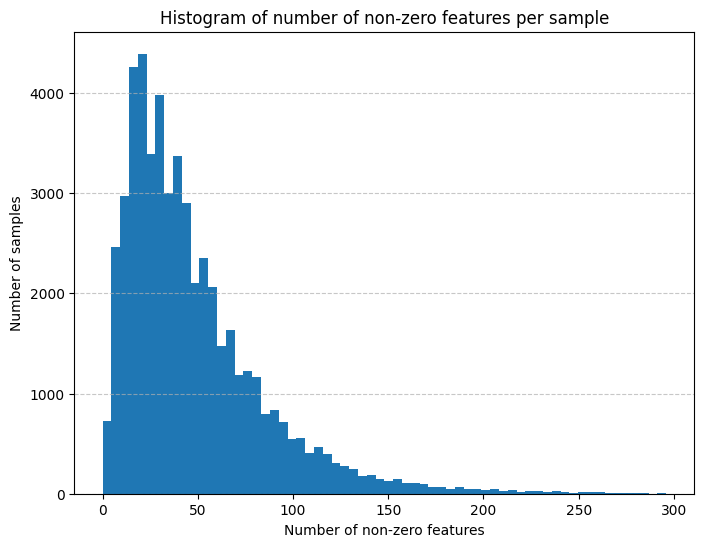

In [6]:
non_zero_counts = np.diff(train_tfidf_features.indptr)
print(f"Average number of non-zero features in samples: {non_zero_counts.mean():.2f}")

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(non_zero_counts, bins=64)
plt.title('Histogram of number of non-zero features per sample')
plt.xlabel('Number of non-zero features')
plt.ylabel('Number of samples')
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [7]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Create appropriate datasets using tfidf matrices
def make_dataset(tfidf_matrix, labels):
  dense_features = tfidf_matrix.astype(np.float32).todense()
  dataset = TensorDataset(torch.tensor(dense_features), torch.tensor(labels, dtype=torch.int64))
  return dataset

datasets = {
    "train": make_dataset(train_tfidf_features, train_dataset["label"]),
    "val": make_dataset(val_tfidf_features, val_dataset["label"]),
    "test": make_dataset(test_tfidf_features, test_dataset["label"])
}


train_loader = DataLoader(datasets["train"], shuffle=True, batch_size=512)
val_loader = DataLoader(datasets["val"], shuffle=False, batch_size=512)
test_loader = DataLoader(datasets["test"], shuffle=False, batch_size=512)

loaders = {"train" : train_loader,
           "val": val_loader,
           "test": test_loader}

In [8]:
import torch.nn as nn

# Different architectures
class SimpleNet(nn.Module):
  def __init__(self, vocab_size: int, num_classes: int):
     super().__init__()
     self.fc1 = nn.Linear(vocab_size, 128)
     self.fc2 = nn.Linear(128, num_classes)
     self.relu = nn.ReLU()
     self.batchNorm1 = nn.BatchNorm1d(128)
     self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = self.dropout(self.relu(self.batchNorm1(self.fc1(x))))
    logits = self.dropout(self.relu(self.fc2(x)))
    return logits


class MediumNet(nn.Module):
  def __init__(self, vocab_size: int, num_classes: int):
     super().__init__()
     self.fc1 = nn.Linear(vocab_size, 256)
     self.fc2 = nn.Linear(256, 128)
     self.fc3 = nn.Linear(128, num_classes)
     self.relu = nn.ReLU()
     self.dropout = nn.Dropout(0.2)
     self.batchNorm1 = nn.BatchNorm1d(256)
     self.batchNorm2 = nn.BatchNorm1d(128)

  def forward(self, x):
    x = self.dropout(self.relu(self.batchNorm1(self.fc1(x))))
    x = self.dropout(self.relu(self.batchNorm2(self.fc2(x))))
    logits = self.fc3(x)
    return logits

class LargeNet(nn.Module):
  def __init__(self, vocab_size: int, num_classes: int):
    super().__init__()
    self.fc1 = nn.Linear(vocab_size, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 128)
    self.fc4 = nn.Linear(128, num_classes)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.2)
    self.batchNorm1 = nn.BatchNorm1d(512)
    self.batchNorm2 = nn.BatchNorm1d(256)
    self.batchNorm3 = nn.BatchNorm1d(128)

  def forward(self, x):
    x = self.dropout(self.relu(self.batchNorm1(self.fc1(x))))
    x = self.dropout(self.relu(self.batchNorm2(self.fc2(x))))
    x = self.dropout(self.relu(self.batchNorm3(self.fc3(x))))
    logits = self.fc4(x)
    return logits

In [10]:
import torchmetrics

# Training Loop
def train(model: nn.Module, loaders: dict[DataLoader], criterion: nn.Module,
          optimizer: torch.optim.Optimizer, lr_scheduler, num_epochs: int, device):

  metric_loss = torchmetrics.aggregation.MeanMetric().to(device)
  metric_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=5).to(device)
  earlyStopping = EarlyStopping(patience=5, delta=0.0001)

  # Run all epochs
  for epoch in range(1, num_epochs+1):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        for X_batch, target in tqdm(loaders[phase]):
            X_batch, target = X_batch.to(device), target.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                logits = model(X_batch)
                _, preds = torch.max(logits, dim=1)
                loss = criterion(logits, target)

                metric_loss(loss)
                metric_acc(preds, target)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

        accuracy = metric_acc.compute()
        mean_loss = metric_loss.compute()

        current_lr = lr_scheduler.get_last_lr()[0]
        print(f"(Epoch {epoch}/[{phase}]) Loss:\t{mean_loss:.3f}   Accuracy: {accuracy:.3f}   lr: {current_lr}")
        metrics = {
            f"{phase}/loss": mean_loss,
            f"{phase}/accuracy": accuracy,
            f"{phase}/lr": current_lr,
        }
        wandb.log(metrics, step=epoch)

        metric_loss.reset()
        metric_acc.reset()

    earlyStopping(mean_loss, model)
    if earlyStopping.early_stop:
      print(f"{20*'-'}Early stopping{20*'-'}")
      break
    lr_scheduler.step()

  earlyStopping.load_best_model(model)

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.best_model_state = model.state_dict()
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)




In [ ]:
# Setting methods and parameters for training

device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

num_epochs = 25
criterion = nn.CrossEntropyLoss()
classifiers = {"model2" : MediumNet(vocab_size, 5)}

for name, model in classifiers.items():
  print(f"Training model: {name}")
  model = model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=5e-3)
  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
  run = wandb.init(
    project="3DifferentNets",
    name=name,
    config={
        "model": name,
        "vocab_size": vocab_size,
        "num_classes": 5,
        "lr": 5e-3,
        "num_epochs": num_epochs
    }
  )
  train(model, loaders, criterion, optimizer, lr_scheduler, num_epochs, device)
  run.finish()

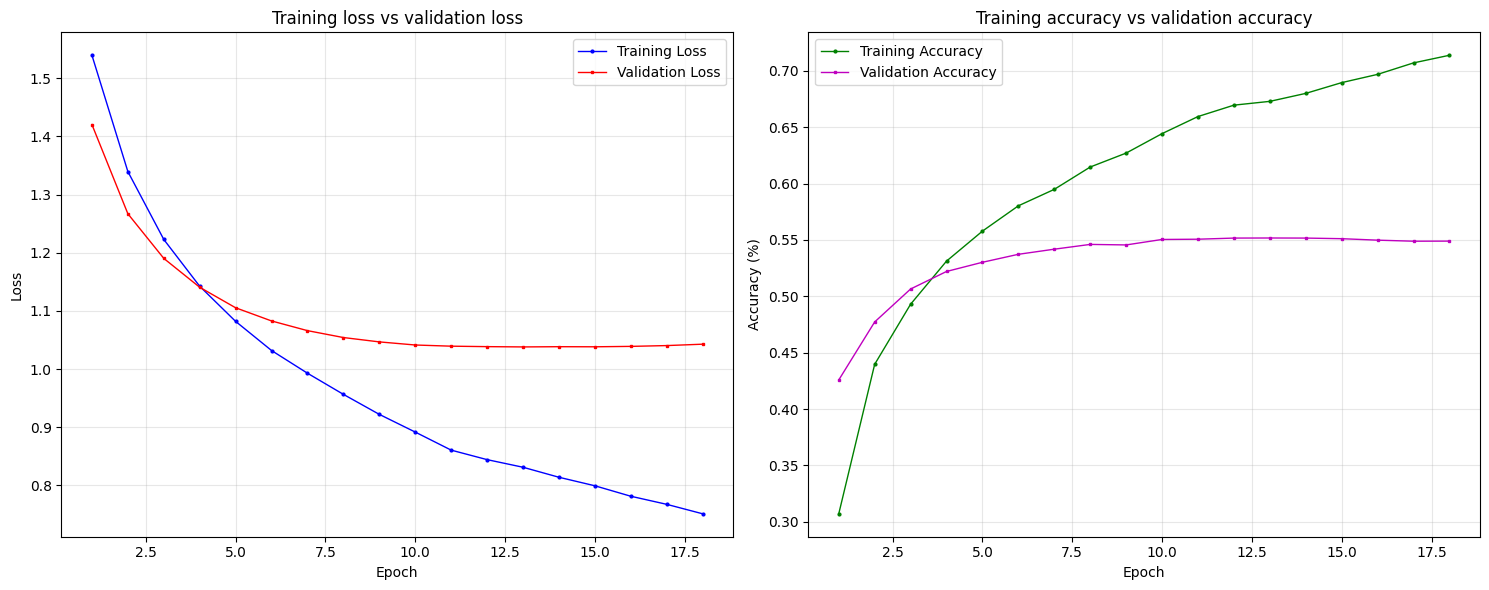

In [15]:
# Results visualization
def create_loss_plot(train_losses,
                     val_losses,
                     train_accuracies,
                     val_accuracies):

  epochs = range(1, len(train_losses) + 1)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


  # Loss plot
  ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=1, marker='o', markersize=2)
  ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=1, marker='s', markersize=2)

  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.set_title('Training loss vs validation loss')
  ax1.legend()
  ax1.grid(True, alpha=0.3)

  # Accuracy plot
  ax2.plot(epochs, train_accuracies, 'g-', label='Training Accuracy', linewidth=1, marker='o', markersize=2)
  ax2.plot(epochs, val_accuracies, 'm-', label='Validation Accuracy', linewidth=1, marker='s', markersize=2)

  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy (%)')
  ax2.set_title('Training accuracy vs validation accuracy')
  ax2.legend()
  ax2.grid(True, alpha=0.3)

  plt.tight_layout()
  plt.show()

api = wandb.Api()
run = api.run("kacper-pt119-warsaw-university-of-technology/3DifferentNets/runs/y5zw21i9")

history = run.history(keys=["train/loss","val/loss","train/accuracy","val/accuracy"])
train_losses = history["train/loss"].to_list()
val_losses   = history["val/loss"].to_list()
train_acc    = history["train/accuracy"].to_list()
val_acc      = history["val/accuracy"].to_list()
create_loss_plot(train_losses, val_losses, train_acc, val_acc)

              precision    recall  f1-score   support

           0       0.65      0.72      0.68      3989
           1       0.49      0.44      0.46      4091
           2       0.45      0.43      0.44      3925
           3       0.47      0.44      0.45      4061
           4       0.60      0.67      0.64      3934

    accuracy                           0.54     20000
   macro avg       0.53      0.54      0.53     20000
weighted avg       0.53      0.54      0.53     20000



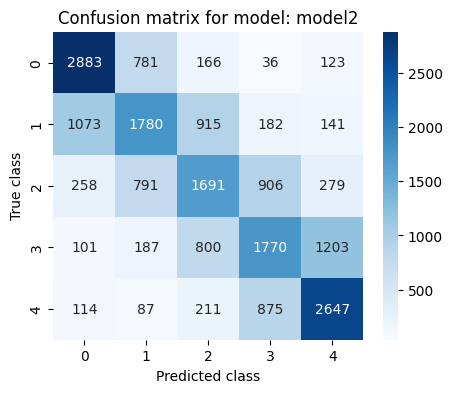

In [16]:
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Model evaluation
def get_data_to_eval(model, data_loader, criterion):
  model.eval()
  preds_l = []
  targets_l = []
  with torch.inference_mode():
      for inputs, targets in data_loader:
          device = next(model.parameters()).device
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)
          preds_l.extend(predicted.cpu().numpy())
          targets_l.extend(targets.cpu().numpy())
  return preds_l, targets_l

for name, model in classifiers.items():
  preds, targets = get_data_to_eval(model, loaders["test"], criterion)
  labels = [str(i) for i in range(0,5)]

  report = classification_report(targets, preds, target_names = labels)
  print(report)

  # Confusion matrix
  cm = confusion_matrix(targets, preds)
  plt.figure(figsize=(5, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
  plt.title(f'Confusion matrix for model: {name}')
  plt.xlabel('Predicted class')
  plt.ylabel('True class')
  plt.show()

A function that finds and displays $k$ elements of the test set for which the model is most wrong, i.e., predicts the smallest probabilities of the true class. Softmax is a strictly increasing function, so it is enough to find elements with the smallest value of unnormalized output from the network (logit) for the true class.

In [ ]:
def show_worst_predictions(model, data_loader, k=10):
    model.eval()
    device = next(model.parameters()).device
    mistakes = []

    with torch.inference_mode():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            logits = model(inputs)
            preds = torch.argmax(logits, dim=1)

            # Get logits for True class
            true_class_logits = logits.gather(1, targets.unsqueeze(1)).squeeze(1)

            for i in range(targets.size(0)):
                mistakes.append((true_class_logits[i].item(), inputs[i].cpu(), targets[i].item(), preds[i].item()))

    mistakes.sort(key=lambda x: x[0])

    print(f"Top {k} the most wrong predicted elements:")
    for i in range(k):
        logit, x, target, pred = mistakes[i]
        print(f"{i+1}. True class: {target}, Predicted class: {pred}, Logit for true class: {logit:.4f}")

    return mistakes[:k]

for name, model in classifiers.items():
  print(f"\nModel: {name}")
  show_worst_predictions(model, loaders["test"])


Model: model2
Top 10 the most wrong predicted elements:
1. True class: 0, Predicted class: 2, Logit for true class: -3.2173
2. True class: 4, Predicted class: 1, Logit for true class: -3.0492
3. True class: 0, Predicted class: 4, Logit for true class: -2.8106
4. True class: 0, Predicted class: 4, Logit for true class: -2.8047
5. True class: 3, Predicted class: 0, Logit for true class: -2.8032
6. True class: 4, Predicted class: 1, Logit for true class: -2.8019
7. True class: 4, Predicted class: 0, Logit for true class: -2.7780
8. True class: 4, Predicted class: 2, Logit for true class: -2.7193
9. True class: 0, Predicted class: 4, Logit for true class: -2.5667
10. True class: 0, Predicted class: 3, Logit for true class: -2.5342
